In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ls /content/gdrive/MyDrive/dataset/train

angry  disgusted  fearful  happy  neutral  sad	surprised


Epoch 1/20
10/10 [==============================] - 5s 295ms/step - loss: 1.9952 - accuracy: 0.1935 - val_loss: 1.9272 - val_accuracy: 0.2063
Epoch 2/20
10/10 [==============================] - 2s 190ms/step - loss: 1.7756 - accuracy: 0.3012 - val_loss: 1.8483 - val_accuracy: 0.2413
Epoch 3/20
10/10 [==============================] - 2s 187ms/step - loss: 1.6309 - accuracy: 0.3923 - val_loss: 1.8063 - val_accuracy: 0.2972
Epoch 4/20
10/10 [==============================] - 2s 188ms/step - loss: 1.5259 - accuracy: 0.4264 - val_loss: 1.8513 - val_accuracy: 0.3112
Epoch 5/20
10/10 [==============================] - 2s 188ms/step - loss: 1.4397 - accuracy: 0.4580 - val_loss: 1.7592 - val_accuracy: 0.3182
Epoch 6/20
10/10 [==============================] - 2s 217ms/step - loss: 1.3216 - accuracy: 0.5324 - val_loss: 1.7626 - val_accuracy: 0.3287
Epoch 7/20
10/10 [==============================] - 2s 188ms/step - loss: 1.2339 - accuracy: 0.5841 - val_loss: 1.7405 - val_accuracy: 0.3392
Epoch 

<Figure size 864x576 with 0 Axes>

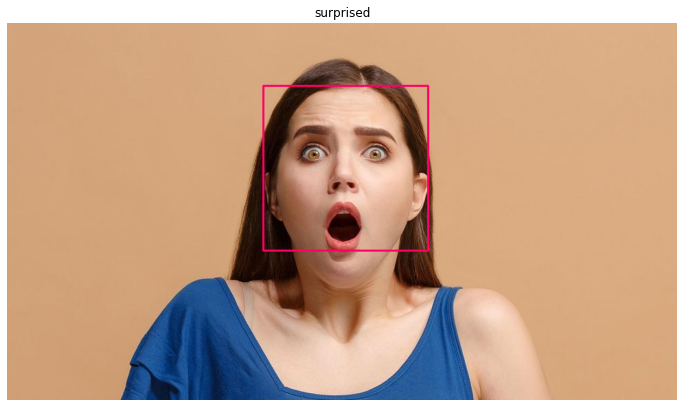

In [15]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 28 14:11:35 2022

@author: aysenurozkan
"""


from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import Sequential,layers, applications, Model 
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os



class PrepareDataset():
    def __init__(self, path:str):
        self.path = path
        self.size = 224
        self.class_names = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

    def readPath(self):
        
        plt.figure(figsize = (12, 8))
        images_labels = []
     
        for category in self.class_names:
          pathD = os.path.join(self.path, category)

          for i in os.listdir(pathD):
            img = cv2.imread(os.path.join(pathD, i))
            img_label = self.class_names.index(category)
            new_img = cv2.resize(img, (self.size, self.size))
            images_labels.append([new_img,self.class_names[img_label]])
                
        return images_labels
    
    def separateShuffle(self, dataset):
        random.shuffle(dataset)
        
        images = []
        labels = []
        
        for img, label in dataset:
            images.append(img)
            labels.append(label)
            
        images = np.array(images).reshape(-1, self.size, self.size, 3)
        
        return images, labels
    
    def normalizeImages(self, images):
        images = images / 255.0
        
        return images
        
    def oneHotEncode(self, labels):
        label_encoder = preprocessing.LabelEncoder()
        labels = label_encoder.fit_transform(labels)
        labels_ohe = to_categorical(labels)
        
        return labels_ohe




class FindEmotion():
    def __init__(self, X_train, y_train, img_path):
        self.size = 224
        self.X_train = X_train
        self.y_train = y_train
        self.img_path = img_path
        self.class_names = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
    
    def setModel(self):
        model = applications.MobileNetV2(weights="imagenet",
                include_top=True,
                input_shape = (self.size, self.size, 3))
        
        model.trainable = False
        base_input = model.layers[0].input
        base_output = model.layers[-2].output
        
        final_output = layers.Dense(128, activation = 'relu')(base_output)
        final_output = layers.Dense(64, activation = 'relu')(final_output)
        final_output = layers.Dense(7, activation = 'softmax')(final_output)
        
        self.new_model = Model(base_input, final_output)
        
        #Training
        keras.optimizers.Adam(
          learning_rate=0.005,
          beta_1=0.9,
          beta_2=0.999,
          epsilon=1e-07,
          amsgrad=False,
          name="Adam")

        self.new_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
        history = self.new_model.fit(self.X_train, self.y_train, epochs = 20, batch_size = 120, validation_split = 0.20)

        print(self.new_model.summary())


    def find_face(self):
      faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
      image = cv2.imread(self.img_path)
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      faces = faceCascade.detectMultiScale(gray, 1.1, 4)

      for x, y, w, h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = image[y:y+h, x:x+w]
        
        cv2.rectangle(image, (x, y), (x+w, y+h), (100, 0, 255), 2)
        facess = faceCascade.detectMultiScale(roi_gray)

        if len(facess) == 0:
          print('Face not detected')
        else:
          for (ex, ey, ew, eh) in facess:
            self.face_roi = roi_color[ey:ey+eh, ex:ex+ew]

      return image

    def find_emotion(self):

      final_image = cv2.resize(self.face_roi, (224, 224))
      final_image = np.expand_dims(final_image, axis = 0)

      predictions = (self.new_model.predict(final_image))

      classes = np.argmax(predictions)
      faces_emotion = self.class_names[classes]

      return faces_emotion



def createDataset(train_dir):
  datasets = PrepareDataset(train_dir)  
  images_labels = datasets.readPath()
  images, labels = datasets.separateShuffle(images_labels)
  X_images = datasets.normalizeImages(images)
  y_labels = datasets.oneHotEncode(labels)
  
  return X_images, y_labels

def predictEmotion(X_train, y_train, img_path):
  schema_model = FindEmotion(X_train, y_train, img_path)
  schema_model.setModel()
  faces = schema_model.find_face()
  faces_emotion = schema_model.find_emotion()


  return faces, faces_emotion


if __name__ == '__main__':

    train_dir = r"/content/gdrive/MyDrive/dataset/train"
    test_dir = r"/content/gdrive/MyDrive/dataset/test"
    img_path = r'/content/gdrive/MyDrive/surprised.jpg'

    X_train, y_train = createDataset(train_dir)
    X_test, y_test= createDataset(test_dir)
    

    faces_image, faces_emotion = predictEmotion(X_train, y_train, img_path)

    plt.title(faces_emotion)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(faces_image, cv2.COLOR_BGR2RGB))
    plt.show()